# Development version 17.3.21:1200

In [185]:
import numpy as np

# This method finds the location of all peaks in the full spectrum
# Output (Indices) contains the start index and end index of each peak
# It is assumed that the structure of the data is coherent.

def findPeakIndices(data):

# each peak in 'data' starts and ends with a zero
# so that there are two zeros between each peak
# =============================================

    n = int(round(sum(data.iloc[:,1] == 0)/2)+1) # n is just the upper limit for the number of peaks
    indices = np.zeros([n,2], dtype="uint32")    # true n may be lower

    ii = 0                                       # index for indices
    indices[ii,0] = 0
    i = 1
    while i < len(data):
        if data.iloc[i,1] == 0:     
            if (i+1) == len(data):
                indices[ii,1] = i
            elif data.iloc[i+1,1] == 0:
                indices[ii,1] = i
                ii = ii+1
                i = i+1
                indices[ii,0] = i
        i = i+1
        
# n may be too large, because there are sometimes single zeros within peaks
# therefore, extra indices are cut out
    indices = indices[0:ii+1,:]
    return indices

# KO 6.4. zeros in the beginning and end are now included in indexed peaks
# Another way to save the indices could also be used: 
# add 1 to every indices[ii,0]
# minus 1 from every indices[ii,1]

In [242]:
from scipy.optimize import leastsq
import numpy as np
import math

def getMean(peak):
    mu = np.average(peak.iloc[:,0], weights=peak.iloc[:,1])  # painotettu keskiarvo

    sigma = mu/(280000*2*np.sqrt(2*np.log(2)))
    fitfunc =  lambda p, x: p[0]*np.exp(-0.5*((x-p[1])/sigma)**2)
    errfunc  = lambda p, x, y: (y - fitfunc(p, x))
    init  = [1.0, mu]

    out = leastsq(errfunc, init, args=(peak.iloc[:,0], peak.iloc[:,1]))                 
    c = out[0]
    return sigma, c[1]

# Modified 3-5.4. by KO

In [243]:
import numpy as np

def getAllMeans(data):
    indices = findPeakIndices(data)
    peakAreas = getAllAreas(data,indices)
    peakSkews = getAllSkews(data,indices)

    n = len(indices)  
    means = np.zeros(n)
    sigmas = np.zeros(n)
    lefts = np.zeros(n)
    rights = np.zeros(n)
    for i in range(n):
        peak = data.iloc[indices[i,0]:indices[i,1]+1,:]
        sigmas[i], means[i] = getMean(peak)
        lefts[i] = indices[i,0]
        rights[i] = indices[i,1]

    return sigmas, means, peakAreas, peakSkews, lefts, rights


In [244]:
import numpy as np

# Get all peak means for the data
def XgetAllMeans(peaks):    # NOT IN USE
    indices = findPeakIndices(peaks)
    n = len(indices[:,0])
    means = []
    aa = []
    sigmas = []
    peaki = []
    for i in range(n):
        peak = peaks[indices[i,0]:indices[i,1]+1,:]
        mu, a, sigma = getMeans(peak)
        for ii in range(len(a)):
            means += [mu[ii]]
            aa += [a[ii]]
            sigmas += [sigma[ii]]
            peaki += [i]
    return means, aa, sigmas, peaki

# This JKo method is not implemented.

## getArea

Actual area of the peak is calculated from the peak histogram.

In [245]:
import numpy as np

def getArea(peak):
    zum = 0                          # channels may have different widths
    for i in range(1,len(peak)-1):
        zum = zum + peak.iloc[i,1]
    zum = zum * (peak.iloc[len(peak)-1,0]-peak.iloc[1,0])/(len(peak)-2)
    return zum

# KO 4.4.

In [246]:
import pandas as pd
import numpy as np

def getAllAreas(data, indices):

    n = len(indices)
    areas = np.zeros(n)
    for i in range(n):
        peak = data.iloc[indices[i,0]:indices[i,1]+1,:]
        areas[i] = getArea(peak)
#    print("all areas ok")
    return areas

# KO 4.4.

In [229]:
import numpy as np
# Pandas has its own skew method.
import pandas as pd

def getSkew(peak):
    dta=peak.iloc[:,1]
    skw = dta.skew(axis = 0)
    return skw

# KO 5.4.

In [247]:
import pandas as pd
import numpy as np

def getAllSkews(data, indices):

    n = len(indices)
    skews = np.zeros(n)
    for i in range(n):
        peak = data.iloc[indices[i,0]:indices[i,1]+1,:]
        skews[i] = getSkew(peak)

    return skews

# KO 9.3.

In [249]:
import pandas as pd
import numpy as np

def getPeak(i, peaklist, interest):
    
    # ion index i is here changed to array index ix 
    for j in range(len(peaklist)):
        if peaklist.iloc[j,12] == i:
            ix = j
    if interest:
        print("Peak of interest: ",peaklist.iloc[ix,0])

    left = int(peaklist.iloc[ix,7])
    right = int(peaklist.iloc[ix,8])
    peak = data[left:right+1]
#    print("L R: ",left,right)    
#    print(peak)  # To show tha actual peak data in numbers
    return ix, peak

# KO 5.4.

## addGaussians

Gaussian model from lmfit library is fitted on each peak.

Center, sigma, and fwhm are saved in the peaklist dataframe.

In [250]:
import pandas as pd
import numpy as np
from lmfit.models import GaussianModel

def addGaussians(peaklist):
    
    for i in range(len(peaklist)):  
        index = peaklist.iloc[i,12]
        ix, peak = getPeak(index,peaklist, False)
        df = pd.DataFrame(peak, columns = ['x','y'])
        cc = len(peak.iloc[:,0])
        df['index'] = np.arange(cc).reshape(cc,1)
        df['x'] = peak.iloc[:,0]
        df['y'] = peak.iloc[:,1]
        df.set_index('index', inplace = True)

        model = GaussianModel()
        params = model.guess(df['y'], x=df['x'])
        result = model.fit(df['y'], params, x=df['x'])
        for parname, param in result.params.items():
#            print("%s = %f +/- %f " % (parname, param.value, param.stderr))
            if parname == 'center':
                centerGv = param.value
            if parname == 'sigma':
                sigmaGv = param.value
            if parname == 'fwhm':
                fwhmGv = param.value
                
        peaklist.iloc[i,9] = centerGv
        peaklist.iloc[i,10] = sigmaGv
        peaklist.iloc[i,11] = fwhmGv
        
# KO 5.4.

In [251]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plotPeak(i, peaklist):

    ix, peak = getPeak(i, peaklist, True)
    
    plt.plot(peak.iloc[:,0],peak.iloc[:,1])
    plt.vlines(peaklist.iloc[ix,2],0,max(peak.iloc[:,1]))
    plt.vlines(peaklist.iloc[ix,1],0,max(peak.iloc[:,1]), color = "green")

    plt.legend(["Data","Mean from data","True mean"])
    plt.title(peaklist.iloc[ix,0])
    plt.show()
    
# KO 5.4.

In [252]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#from lmfit.models import LorentzianModel
from lmfit.models import GaussianModel

def plotGaussian(i, peaklist):
    
    ix, peak = getPeak(i, peaklist, True)  
    
# read the data into a pandas DataFrame, and use the ‘x’ and ‘y’ columns:
# Sata is already in such a dataframe
# dframe = pd.read_csv('peak.csv')

    df = pd.DataFrame(peak, columns = ['x','y'])
    cc = len(peak.iloc[:,0])
    df['index'] = np.arange(cc).reshape(cc,1)
    df['x'] = peak.iloc[:,0]
    df['y'] = peak.iloc[:,1]
#    df['y'] = np.log(peak.iloc[:,1] )  # needs improvement.. log was to handle skewed peaks
    df.set_index('index', inplace = True)
    print(df)

#    model = LorentzianModel()   # was not as good as Gaussian
    model = GaussianModel()
    params = model.guess(df['y'], x=df['x'])
    result = model.fit(df['y'], params, x=df['x'])

# and gives the plot and fitting results below:

    result.plot_fit()
    plt.show()

    print(result.fit_report())

# KO 5.4.

In [253]:
import pandas as pd
import numpy as np

# maxDistance below = 'th' in JKolis's code

def identifyPeaks(data, peaklist, maxDistance):    
    peaklist['observed'] = np.zeros(len(peaklist['mz'])) #2
    peaklist['peak'] = np.zeros(len(peaklist['mz']))     #3
    peaklist['area'] = np.zeros(len(peaklist['mz']))     #4
    peaklist['skew'] = np.zeros(len(peaklist['mz']))     #5
    peaklist['sigma'] = np.zeros(len(peaklist['mz']))    #6
    peaklist['lefti']  = np.zeros(len(peaklist['mz']))   #7
    peaklist['righti'] = np.zeros(len(peaklist['mz']))   #8
    peaklist['centerG'] = np.zeros(len(peaklist['mz']))   #9
    peaklist['sigmaG']  = np.zeros(len(peaklist['mz']))   #10
    peaklist['fwhmG'] = np.zeros(len(peaklist['mz']))   #11    

    sigmas, peakMeans, peakAreas, peakSkews, lefts, rights = getAllMeans(data)
    trueValue = peaklist['mz'].to_numpy()     # get only the mz values from the peaklist

    for i in range(len(trueValue)):
        if min(abs(peakMeans - trueValue[i])) < maxDistance:      # there is at least one
            ind = np.argmin(abs(peakMeans - trueValue[i]))
            peaklist.iloc[i,2] = peakMeans[ind]
            peaklist.iloc[i,3] = np.argmin(abs(peakMeans - trueValue[i]))
            peaklist.iloc[i,4] = peakAreas[ind]
            peaklist.iloc[i,5] = peakSkews[ind]
            peaklist.iloc[i,6] = sigmas[ind]
            peaklist.iloc[i,7] = lefts[ind]
            peaklist.iloc[i,8] = rights[ind]  

    unidentified = np.linspace(0, len(trueValue)-1, len(trueValue))
    unidentified = unidentified[peaklist['observed'].to_numpy() == 0]
  
    identified = np.linspace(0, len(trueValue)-1, len(trueValue))
    identified = identified[peaklist['observed'].to_numpy() != 0]    

#    unidentified: 'observed' == 0, because it never got any actual value

    return peaklist.drop(unidentified)

# Modified by KO 31.3.-6.4.

## readSpectrum

Change the name of the 'dataDir' to match your own folder of spectra.

Parameter n refers to the nth file in your folder.

In [254]:
# Method to read in one spectrum
# You need to give the folder name in this method

# A large number of averaged, denoised spectra was exported from Orbitool into folders
# Exported with Antonio's "all denoised" button

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import glob

def readSpectrum(n):
    dataDir = glob.glob("C:/datascienceproject/raw data/small mass deviation/deno201117n10/*.csv")
    fileName = dataDir[n]
    print("File name: ",fileName)
    df = pd.read_csv(fileName, sep=",")

    print("Shape:      {}, {}".format(*df.shape))
    print()
    data = df.iloc[0:,:2].astype("float64")
    return(data)
    
#fileName = "data/N_minutes_60_N_spectra_10/spectrum_2020-00-17_17_11_07.csv"  # JKo
#return pd.read_csv(fileName).iloc[3:,:2].to_numpy().astype("float64")         # JKo version

# KO method


## "Main program"

Change the name of the 'ionFolder' to match your own folder.

NOTE: Remember to give the 'spectrumNumber', the nth file in the folder of spectra to be read.

NOTE: The spectrumNumber of the first file in the folder is 0.

File name:  C:/datascienceproject/raw data/small mass deviation/deno201117n10\2020-11-17T16-56-06.csv
Shape:      1593, 2

Number of actual recognized peaks:  77
            formula          mz    observed  peak        area      skew  \
1              O3N-   61.988366   61.988375   5.0  479.288306  6.677467   
2          O3N[15]-   62.985401   62.985424  10.0    1.654313  0.964888   
3         O2O[17]N-   62.992584   62.992606  11.0    0.419329  0.875841   
4         O2O[18]N-   63.992613   63.992622  12.0    2.974983  0.985926   
8           C4H5O2-   85.029503   85.029595  15.0    0.064197  0.469239   
9            C2HO4-   88.988032   88.988112  17.0    0.714313  0.618982   
15          C3H3O4-  103.003682  103.003769  18.0    2.972596  0.966201   
20          C2O2F3-  112.985587  112.985664  20.0    0.161726  0.300602   
25          C4H5O4-  117.019332  117.019384  21.0    0.628127  0.699530   
28          CH2O6N-  123.988760  123.988736  22.0    0.439405  0.465746   
29           

C:\Users\kojal\anaconda3\envs\orbitool\lib\site-packages\ipykernel_launcher.py:61: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


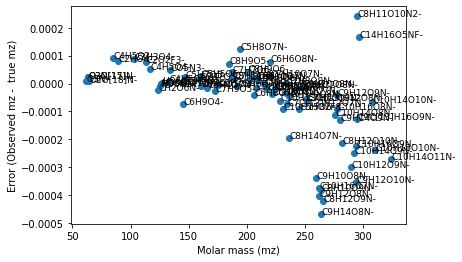

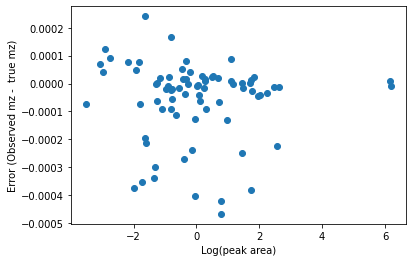

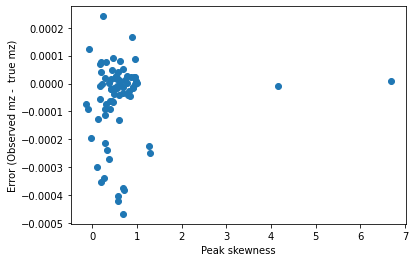


If skewness is less than -1 or greater than 1, the distribution is highly skewed.
If skewness is between -1 and -0.5 or between 0.5 and 1, the distribution is moderately skewed.
If skewness is between -0.5 and 0.5, the distribution is approximately symmetric.

Negative skewness: peak top is to the right from the mean (bigger tail on the left).


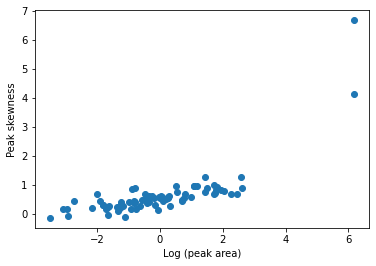

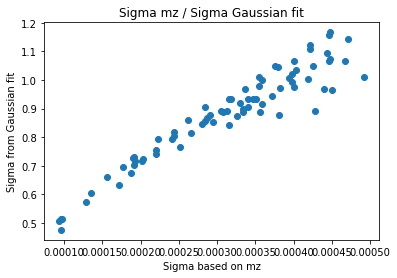

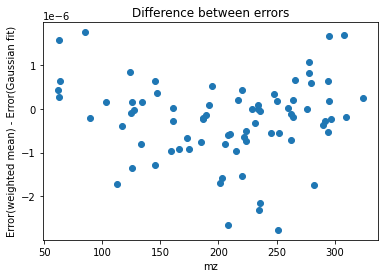

In [255]:
# Main program here

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

spectrumNumber = 0         
data = readSpectrum(spectrumNumber)    # Read the nth file in the folder of spectra

# print(data[340:353])      # Just in case, if you want to print some values from the dataframe

ionFolder = "C:/Users/kojal/pyharj/DSpro/KOionfolder/"  # Has a different structure than JKo ion file
ionFileName = ionFolder + "Allions1ex.csv"
peaklist = identifyPeaks(data, pd.read_csv(ionFileName, sep=","), 0.001)
# Rightmost value just above is the maximum alloved distance between true and observed peak

peaklist['idx'] = peaklist.index.to_numpy()    # Add index value into column 12

addGaussians(peaklist)

peaklist['error'] = peaklist['observed'] - peaklist['mz']
peaklist['errorG'] = peaklist['centerG'] - peaklist['mz']

print("Number of actual recognized peaks: ",len(peaklist))
pd.set_option('display.max_rows', len(peaklist))
print(peaklist)   # Helps to find the number of the peak of interest
pd.reset_option('display.max_rows')


# Plot any ion of interest: first parameter indicates the ion number

#plotPeak(2,peaklist)
#plotPeak(8,peaklist)
#plotPeak(215,peaklist)
#plotPeak(269,peaklist)

# Plot any ion peak with Gaussian fit

#plotGaussian(2, peaklist)
#plotGaussian(8, peaklist)
#plotGaussian(215, peaklist)

# plotPeak and plotGaussian are now done in separate windows below.


# Plot some interesting graphs

xmz = peaklist['mz']
ydiff = peaklist['observed'] - peaklist['mz'] 
names = peaklist['formula']
pit = len(xmz)

y = ydiff
x = xmz
fig = plt.figure()
plt.scatter(x,y)


k = names
# To see the names of compounds in the graph, uncomment these lines:
ax = fig.add_subplot(111)   # subplot not working as expected
for i,j,k in zip(x,y,k):
    ax.annotate(str(k),xy=(i+0.4,j), fontsize = 9)

plt.xlabel("Molar mass (mz)")
plt.ylabel("Error (Observed mz -  true mz)")
#plt.figure(figsize=(3,2))           # not working right
#plt.figure(figsize=(6, 4), dpi=70)  # not working right
plt.show()


logarea = np.log(peaklist['area'])
x = logarea
y = ydiff
fig = plt.figure()
plt.scatter(x,y)

# To see the names of compounds in the graph, uncomment these 2 lines:
#for i,j,k in zip(x,y,k):
#    ax.annotate(str(k),xy=(i+0.4,j), fontsize = 9)

plt.xlabel("Log(peak area)")
plt.ylabel("Error (Observed mz -  true mz)")
plt.show()


x = peaklist['skew']
y = ydiff
fig = plt.figure()
plt.scatter(x,y)

# To see the names of compounds in the graph, uncomment these 2 lines:
#for i,j,k in zip(x,y,k):
#    ax.annotate(str(k),xy=(i+0.4,j), fontsize = 9)

plt.xlabel("Peak skewness")
plt.ylabel("Error (Observed mz -  true mz)")
plt.show()

print()
print("If skewness is less than -1 or greater than 1, the distribution is highly skewed.")
print("If skewness is between -1 and -0.5 or between 0.5 and 1, the distribution is moderately skewed.")
print("If skewness is between -0.5 and 0.5, the distribution is approximately symmetric.")
print()
print("Negative skewness: peak top is to the right from the mean (bigger tail on the left).")

x = logarea
y = peaklist['skew']
fig = plt.figure()
plt.scatter(x,y)

# To see the names of compounds in the graph, uncomment these 2 lines:
#for i,j,k in zip(x,y,k):
#    ax.annotate(str(k),xy=(i+0.4,j), fontsize = 9)

plt.xlabel("Log (peak area)")
plt.ylabel("Peak skewness")
plt.show()


x = peaklist['sigma']
y = peaklist['sigmaG']/peaklist['sigma']
fig = plt.figure()
plt.scatter(x,y)

# To see the names of compounds in the graph, uncomment these 2 lines:
#for i,j,k in zip(x,y,k):
#    ax.annotate(str(k),xy=(i+0.4,j), fontsize = 9)

plt.xlabel("Sigma based on mz")
plt.ylabel("Sigma from Gaussian fit")
plt.title("Sigma mz / Sigma Gaussian fit")
plt.show()


x = peaklist['mz']
y = peaklist['error']-peaklist['errorG']
fig = plt.figure()
plt.scatter(x,y)

# To see the names of compounds in the graph, uncomment these 2 lines:
#for i,j,k in zip(x,y,k):
#    ax.annotate(str(k),xy=(i+0.4,j), fontsize = 9)

plt.xlabel("mz")
plt.ylabel("Error(weighted mean) - Error(Gaussian fit)")
plt.title("Difference between errors")
plt.show()


# KOj 19.3. and 31.3-6.4.

## plotPeak

Choose a peak index from the printed dataframe (above) and
plot the peak for the formula in question.

NOTE:  Peak index that is not in the dataframe gives an error. (to be fixed)

Peak of interest:  C4H5O2-


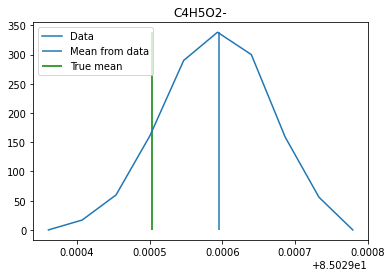

In [257]:
plotPeak(8,peaklist)  # 2, 8, 215, 269

## plotGaussian

Choose a peak index from the printed dataframe (above) and

plot the peak data and Gaussian fit data for the formula in question.

NOTE:  Peak index that is not in the dataframe gives an error. (to be fixed)

Peak of interest:  C4H5O2-
               x           y
index                       
0      85.029361    0.000000
1      85.029407   16.959652
2      85.029454   59.850291
3      85.029500  161.005564
4      85.029547  290.012500
5      85.029593  338.252022
6      85.029640  300.044305
7      85.029686  158.969722
8      85.029733   55.976886
9      85.029779    0.000000


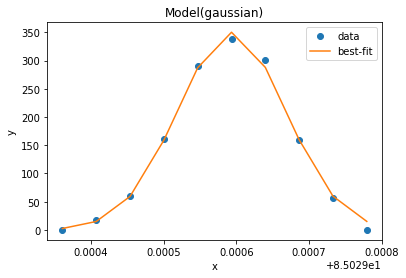

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 10
    # variables        = 3
    chi-square         = 553.414761
    reduced chi-square = 79.0592516
    Akaike info crit   = 46.1352265
    Bayesian info crit = 47.0429818
[[Variables]]
    amplitude:  0.06500860 +/- 0.00120687 (1.86%) (init = 0.04716935)
    center:     85.0295934 +/- 1.5938e-06 (0.00%) (init = 85.02959)
    sigma:      7.4083e-05 +/- 1.5927e-06 (2.15%) (init = 4.648344e-05)
    fwhm:       1.7445e-04 +/- 3.7504e-06 (2.15%) == '2.3548200*sigma'
    height:     350.075524 +/- 6.50507988 (1.86%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) =  0.578


In [258]:
plotGaussian(8, peaklist)
